Epoch 1/20


2024-05-16 14:16:26.447654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:26.895970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:26.914028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:27.251033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:27.268571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:27.787157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:27.812861: I tensorflow/core/grappler/optimizers/cust

    1/13575 [..............................] - ETA: 14:04:01 - loss: 0.4952 - accuracy: 0.5312

2024-05-16 14:16:28.165634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:16:28.191400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13575/13575 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.8632

2024-05-16 14:22:23.457992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:22:23.612872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:22:23.627633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:22:23.720651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:22:23.733307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13575/13575 [==============================] - 393s 29ms/step - loss: 0.2876 - accuracy: 0.8632 - val_loss: 0.2012 - val_accuracy: 0.9243
Epoch 2/20
13575/13575 [==============================] - 373s 27ms/step - loss: 0.1506 - accuracy: 0.9408 - val_loss: 0.1519 - val_accuracy: 0.9571
Epoch 3/20
13575/13575 [==============================] - 384s 28ms/step - loss: 0.1348 - accuracy: 0.9500 - val_loss: 0.1218 - val_accuracy: 0.9663
Epoch 4/20
13575/13575 [==============================] - 381s 28ms/step - loss: 0.1376 - accuracy: 0.9541 - val_loss: 0.1426 - val_accuracy: 0.9589
Epoch 5/20
13575/13575 [==============================] - 383s 28ms/step - loss: 0.1322 - accuracy: 0.9567 - val_loss: 0.1269 - val_accuracy: 0.9573
Epoch 6/20
13575/13575 [==============================] - 371s 27ms/step - loss: 0.1296 - accuracy: 0.9555 - val_loss: 0.1377 - val_accuracy: 0.9586


2024-05-16 14:54:29.695237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:54:29.846225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:54:29.859615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   7/4242 [..............................] - ETA: 39s  

2024-05-16 14:54:29.956402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-16 14:54:29.969009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4242/4242 [==============================] - 35s 8ms/step


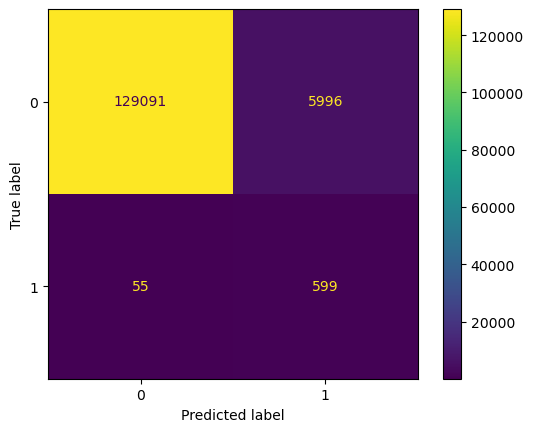

Final Test Accuracy: 0.9554
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    135087
           1       0.09      0.92      0.17       654

    accuracy                           0.96    135741
   macro avg       0.55      0.94      0.57    135741
weighted avg       1.00      0.96      0.97    135741



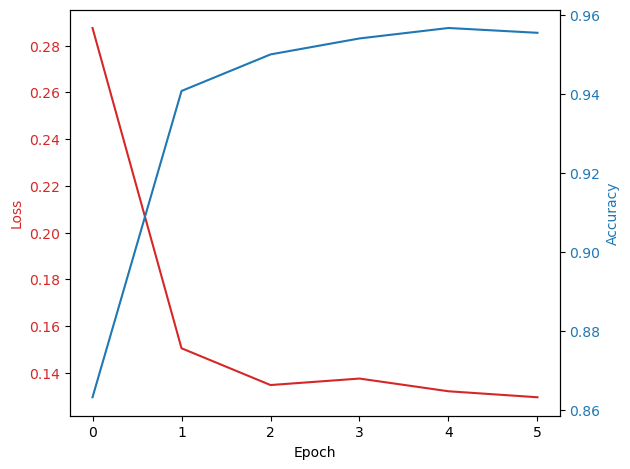

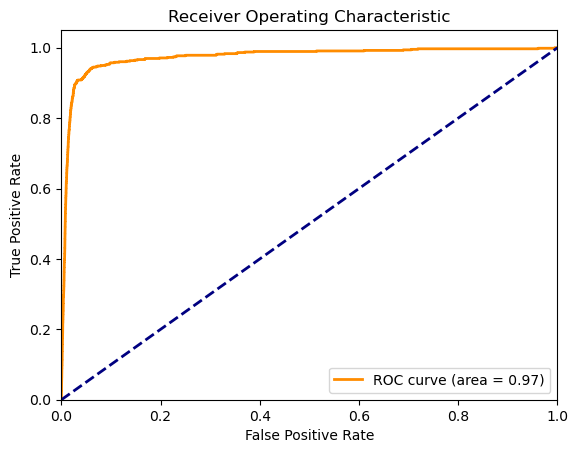

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load data
files = [
    'Data/29_tracks_labeled.csv', 'Data/28_tracks_labeled.csv', 'Data/27_tracks_labeled.csv', 
    'Data/26_tracks_labeled.csv', 'Data/25_tracks_labeled.csv', 'Data/22_tracks_labeled.csv', 
    'Data/21_tracks_labeled.csv', 'Data/20_tracks_labeled.csv'
]
data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

# Sort data by time if there's a timestamp column
data = data.sort_values(by=['frame'])

# Split data chronologically
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Assuming the datasets have been properly labeled and contain the 'stopped_before_pedestrian' column
features_cols = ['xCenter', 'yCenter', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'latAcceleration']

# Split features and labels for training data
X_train = train_data[features_cols]
y_train = train_data['stopped_before_pedestrian']

# Split features and labels for testing data
X_test = test_data[features_cols]
y_test = test_data['stopped_before_pedestrian']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Adjust the time steps to a larger value
time_steps = 10  # Adjust as needed based on the data

# Ensure the number of samples is a multiple of the time steps
num_samples = (X_train.shape[0] // time_steps) * time_steps
X_train = X_train[:num_samples]
y_train = y_train[:num_samples]

num_samples_test = (X_test.shape[0] // time_steps) * time_steps
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]

# Reshape y_train and y_test to match the number of sequences
y_train = np.array(y_train).reshape((-1, time_steps))[:, 0]
y_test = np.array(y_test).reshape((-1, time_steps))[:, 0]

# Reshape data for LSTM: [samples, time_steps, features]
X_train = X_train.reshape((-1, time_steps, X_train.shape[1]))
X_test = X_test.reshape((-1, time_steps, X_test.shape[1]))

# Train/validation split from training data
train_val_split = int(0.8 * len(X_train))
X_train_final = X_train[:train_val_split]
X_val = X_train[train_val_split:]
y_train_final = y_train[:train_val_split]
y_val = y_train[train_val_split:]

# Build the simplified LSTM model with BatchNormalization and Bidirectional LSTM
model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2]))),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(50, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with increased epochs and adjusted batch size
history = model.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print final accuracy and classification report
final_accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print(classification_report(y_test, y_pred_classes))

# Plot training loss and accuracy
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.epoch, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(history.epoch, history.history['accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
